# Kaggle : New York City Taxi Trip Duration

# 1. Data import 

In [1]:
train = pd.read_csv("./taxi.csv")

In [2]:
import pandas as pd
import numpy as np
import random
#import missingno as msno

import requests
import folium

import seaborn as sns
import matplotlib.pylab as plt
%matplotlib inline

from datetime import datetime, timedelta

import os

from matplotlib.pyplot import *


from matplotlib import cm
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from dateutil import parser
from scipy import stats

import base64

from subprocess import check_output

# 2. Data Preview

### * Data fields : 1458644 rows * 11 columns
### [column description]
- id: a unique identifier for each trip
- vendor_id: a code indicating the provider associated with the trip record
- pickup_datetime: date and time when the meter was engaged
- dropoff_datetime: date and time when the meter was disengaged
- passenger_count: the number of passengers in the vehicle (driver entered value)
- pickup_longitude: the longitude where the meter was engaged
- pickup_latitude: the latitude where the meter was engaged
- dropoff_longitude: the longitude where the meter was disengaged
- dropoff_latitude: the latitude where the meter was disengaged
- store_and_fwd_flag: This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
- trip_duration : duration of the trip in second

## * Missing data : No missing values

In [3]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


## * Outlier check: trip_duration 변수에 outlier 있음을 확인

In [5]:
aa = pd.DataFrame(train['trip_duration'])

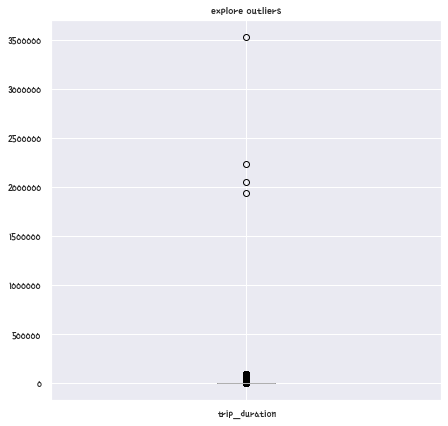

In [6]:
plt.subplots(figsize=(7,7))
plt.title("explore outliers")
aa.boxplot();

In [7]:
target = train['trip_duration']
print("최대값: {} (초) / {} 분" .format(np.max(target.values), np.max(target.values)//60))
print("최소값: {} (초) / {} 분".format(np.min(target.values),np.min(target.values)//60))
print("평균 : {} (초) / {} 분".format(np.mean(target.values), np.mean(target.values)//60))

최대값: 3526282 (초) / 58771 분
최소값: 1 (초) / 0 분
평균 : 959.4922729603659 (초) / 15.0 분


### outlier 제거

In [8]:
q1 = np.quantile(train['trip_duration'], 0.25)
q2 = np.quantile(train['trip_duration'], 0.5)
q3 = np.quantile(train['trip_duration'], 0.75) 
q4 = np.quantile(train['trip_duration'], 1) 

In [9]:
#분으로 환산
print(q1//60, q2//60, q3//60, q4//60)

6.0 11.0 17.0 58771


In [10]:
IQR=(q3-q1)*1.5

In [11]:
limit = q3 + IQR

In [12]:
outlier = train[train['trip_duration'] > limit].index
train = train.drop(outlier)
train

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435
5,id0801584,2,2016-01-30 22:01:40,2016-01-30 22:09:03,6,-73.982857,40.742195,-73.992081,40.749184,N,443
...,...,...,...,...,...,...,...,...,...,...,...
1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,N,778
1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,N,655
1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,N,764
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,N,373


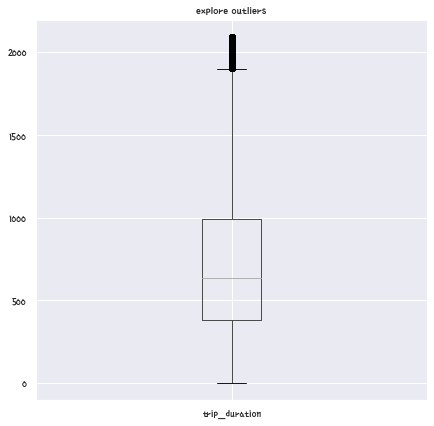

In [13]:
aa = pd.DataFrame(train['trip_duration'])
plt.subplots(figsize=(7,7))
plt.title("explore outliers")
aa.boxplot();

## 3. Column data review

### 1) 택시 업체(vendor_id)

In [14]:
pd.pivot_table(train, index="vendor_id", values="id", aggfunc = "count")

,id
vendor_id,
1,645809
2,738615


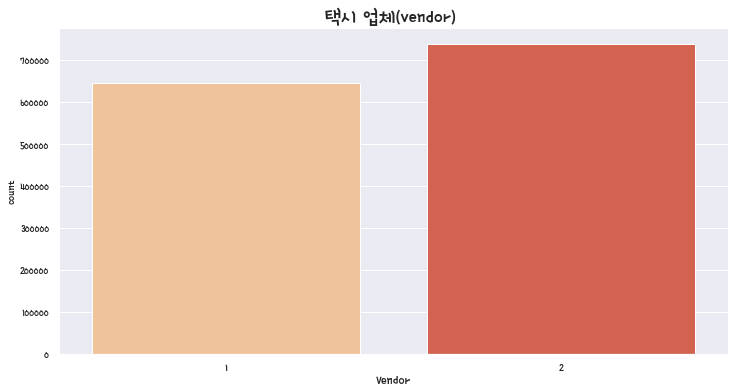

In [15]:
f = plt.figure(figsize=(12,6))
sns.countplot(x="vendor_id", data=train, palette=sns.color_palette("OrRd", n_colors=2))
plt.title("택시 업체(vendor) ", fontsize=20) 
plt.xlabel('Vendor', fontsize=14)
plt.show()

### 2) passengers count column

In [16]:
pd.pivot_table(train, index="passenger_count", values="id", aggfunc = "count")

,id
passenger_count,
0,56
1,983883
2,197635
3,56558
4,26618
5,73864
6,45805
7,3
8,1


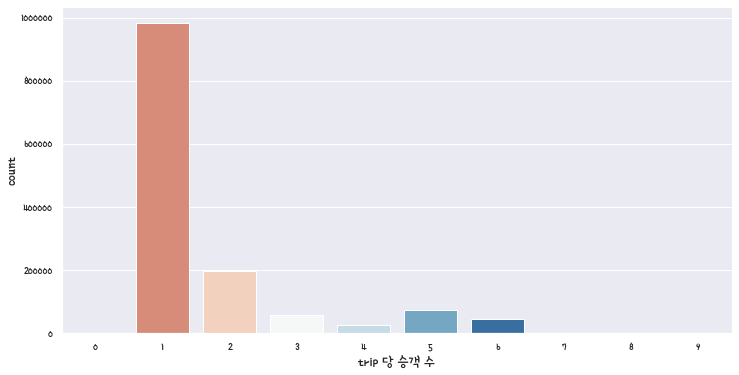

In [17]:
f = plt.figure(figsize=(12,6))
sns.countplot(x="passenger_count", data=train, palette=sns.color_palette("RdBu", n_colors=7))
plt.xlabel('trip 당 승객 수', fontsize=14)
plt.ylabel('count', fontsize=14)
plt.show()

### 3) store_and_fwd_flag

In [18]:
pd.pivot_table(train, index="store_and_fwd_flag", values="id", aggfunc = "count")

,id
store_and_fwd_flag,
N,1377360
Y,7064


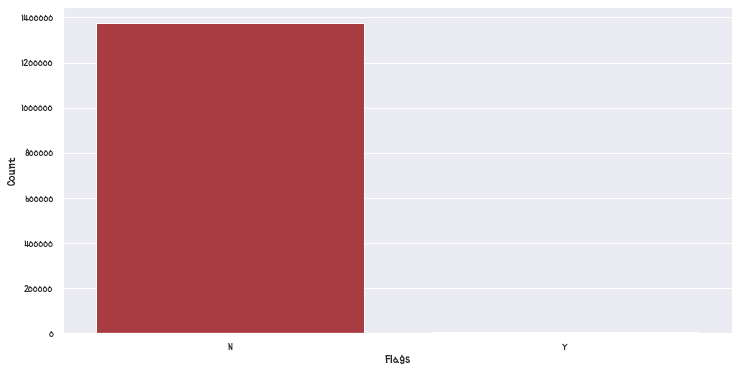

In [19]:
f = plt.figure(figsize=(12,6))
sns.countplot(x="store_and_fwd_flag", data=train, palette=sns.color_palette("RdBu", n_colors=7))
plt.xlabel('Flags', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.show()

### 4) travel_duration(travel time)

In [21]:
train.pickup_datetime = train.pickup_datetime.apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
train.dropoff_datetime = train.dropoff_datetime.apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
train["tt"] = train.dropoff_datetime - train.pickup_datetime
train["travel_time"] = pd.to_datetime(train['tt']).dt.strftime("%M")

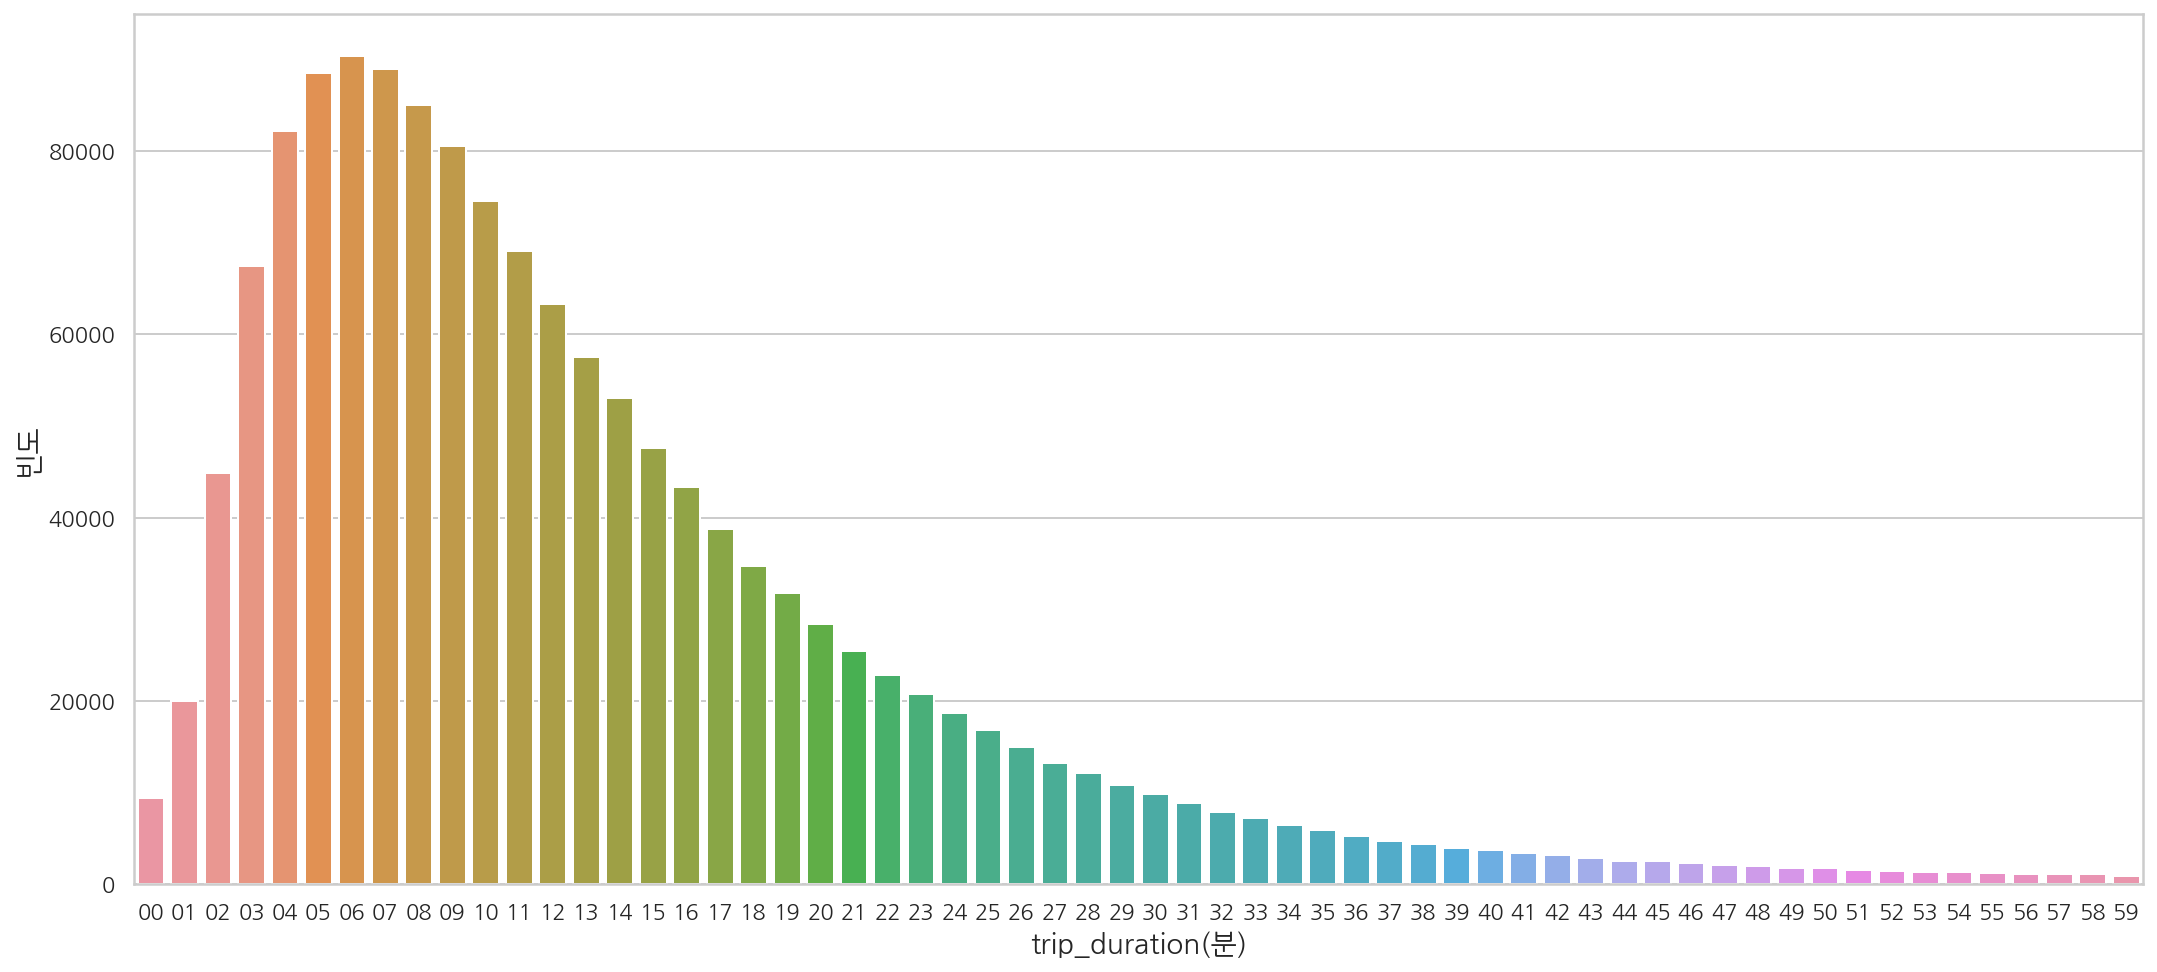

In [14]:
#train.dtypes
f = plt.figure(figsize=(18,8))
sns.countplot(data=train,x = "travel_time")
plt.xlabel('trip_duration(분)', fontsize=14)
plt.ylabel('빈도', fontsize=14)
plt.show()

- 오른쪽 꼬리 분포의 형태를 나타낸다. 
- 로그 변환을 하여 그래프를 그려본다.

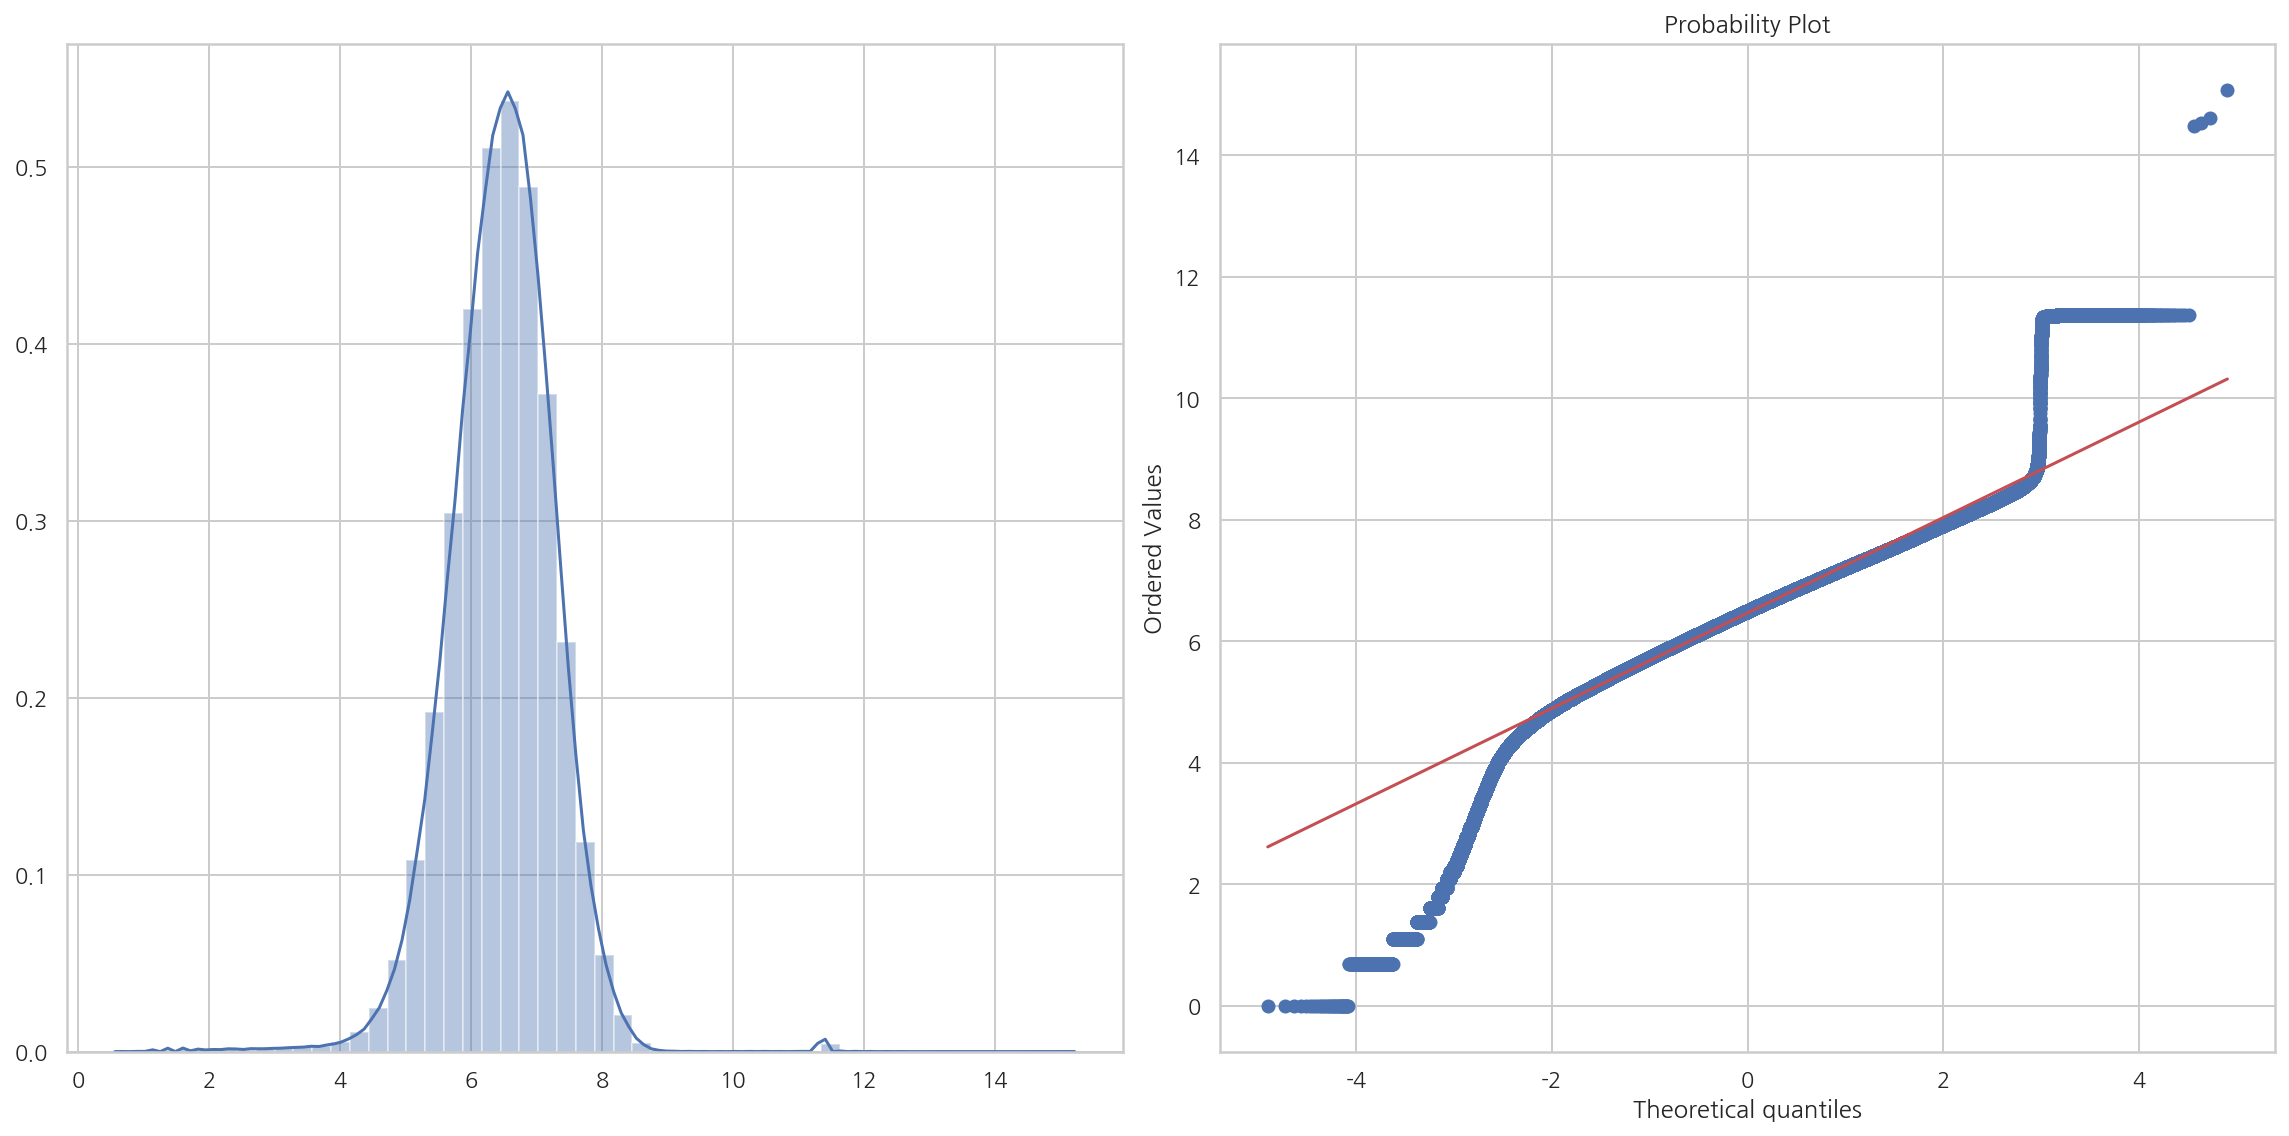

In [15]:
plt.figure(figsize=(16,8))
plt.subplot(121)
sns.distplot(np.log(train['trip_duration'].values+1))
plt.subplot(122)
stats.probplot(np.log(train['trip_duration'].values), plot=plt)
plt.tight_layout()
plt.show()

train['log_trip_duration'] = np.log1p(train['trip_duration'].values)

# 4. 가설 설정
### 1) 겨울, 주말에 택시를 많이 이용할 것이다.
### 2) 퇴근 시간 대에 택시를 많이 이용할 것이다.
### 3) 승객수가 많을수록 특정 포인트에서 많이 탈것이다.
### 4) 날씨가 안좋으면 택시를 많이 이용할 것이다.

# 5. 가설 검증


### 가설 1) 겨울, 주말에 택시 pick up 수가 많을 것이다.

### →  결과: 월별, 요일별 택시 pick up 횟수 확인 결과, 겨울(1-2월) 보다는 3-4월에 이용 빈도가 높음을 확인.

### ① 월별 택시 이용 횟수 피벗테이블, 분포

In [22]:
train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'])
train['dropoff_datetime'] = pd.to_datetime(train['dropoff_datetime'])

train['pickup_day'] = train['pickup_datetime'].dt.day
train['pickup_month'] = train['pickup_datetime'].dt.month
train['pickup_weekday'] = train['pickup_datetime'].dt.weekday
train['pickup_hour'] = train['pickup_datetime'].dt.hour

train['drop_day'] = train['dropoff_datetime'].dt.day
train['drop_month'] = train['dropoff_datetime'].dt.month
train['drop_weekday'] = train['dropoff_datetime'].dt.weekday
train['drop_hour'] = train['dropoff_datetime'].dt.hour

In [23]:
pd.pivot_table(train, index="pickup_month", values="id", aggfunc = "count")

,id
pickup_month,
1,220237
2,228985
3,244550
4,238673
5,232790
6,219189


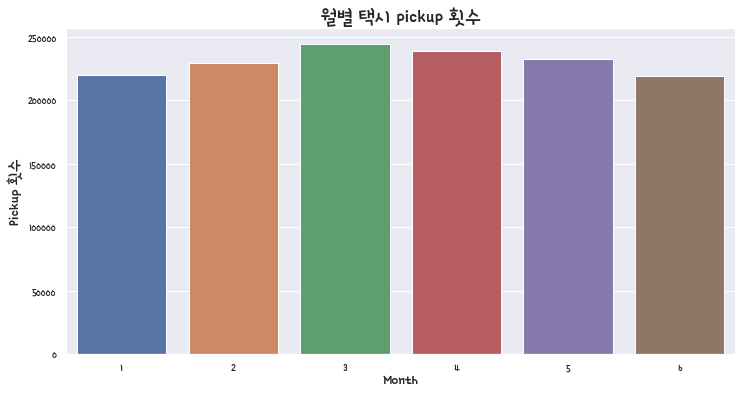

In [24]:
f = plt.figure(figsize=(12,6))
sns.countplot(x='pickup_month', data=train)

plt.title("월별 택시 pickup 횟수", fontsize=20) 
plt.xlabel('Month', fontsize=16)
plt.ylabel('Pickup 횟수', fontsize=16)
plt.show()

### ② 요일별 택시 이용 횟수 피벗테이블, 분포

In [25]:
pd.pivot_table(train, index="pickup_weekday", values="id", aggfunc = "count")

,id
pickup_weekday,
0,178171
1,191913
2,197831
3,204672
4,210997
5,213085
6,187755


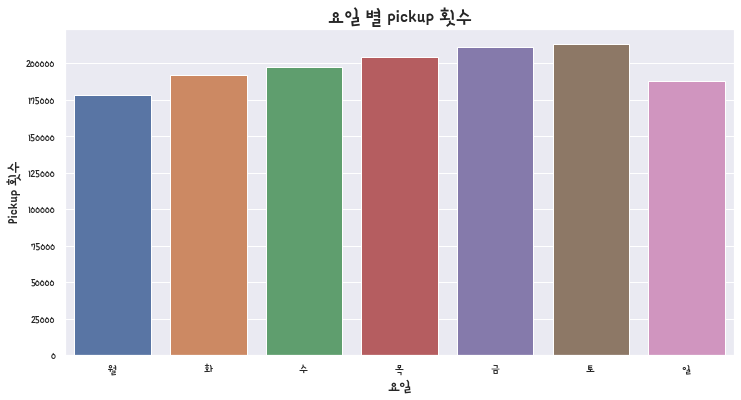

In [26]:
f = plt.figure(figsize=(12,6))
days = [i for i in range(7)]
sns.countplot(x='pickup_weekday', data=train)
plt.title("요일 별 pickup 횟수", fontsize=20) 
plt.xlabel('요일', fontsize=15)
plt.ylabel('Pickup 횟수', fontsize=15)
plt.xticks(days, ('월', '화', '수', '목', '금', '토', '일'))
plt.show()

### 가설 2) 퇴근 시간 대에 택시 pickup 수가 많을 것이다.

### → 결과: 시간대 별 택시 pick up 수가 18시~20시 사이에 가장 많고, 동일 시간 대에 택시의 평균 속도가 가장 느림.

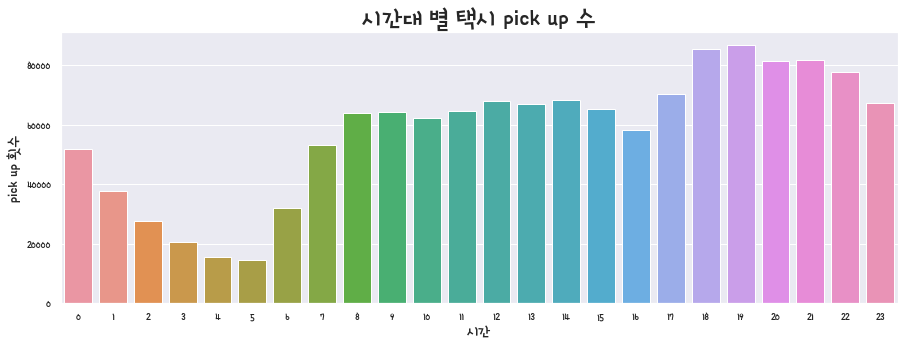

In [27]:
f = plt.figure(figsize=(15,5))
sns.countplot(x='pickup_hour', data=train)
plt.title("시간대 별 택시 pick up 수", fontsize=25) 
plt.xlabel('시간', fontsize=15)
plt.ylabel('pick up 횟수', fontsize=15)
plt.show()

In [28]:
# 거리구해주기
# 맨하탄 거리
def manhattan_distance(x, y):
    return sum(abs(a-b) for a, b in zip(x, y))
# 유클리디안 거리
def euclidean_distance(x, y):
    return np.sqrt(sum(pow(a-b,2) for a, b in zip(x, y))) 

In [29]:
# 유클리디안 거리 계산
# 맨하탄 거리 계산
train['euclidean_distance'] = train.apply(lambda row: euclidean_distance( (row['pickup_latitude'], row['pickup_longitude']), (row['dropoff_latitude'], row['dropoff_longitude']) ), axis=1)
train['manhattan_distance'] = train.apply(lambda row: manhattan_distance( (row['pickup_latitude'], row['pickup_longitude']), (row['dropoff_latitude'], row['dropoff_longitude']) ), axis=1)

In [30]:
train['log_euclidean_distance'] = np.log1p(train['euclidean_distance'])
train['log_manhattan_distance'] = np.log1p(train['manhattan_distance'])
#train.columns

In [31]:
# speed
train.loc[:, 'avg_spped_u'] = 100000 * train['euclidean_distance'] / train['trip_duration']
train.loc[:, 'avg_spped_m'] = 1000 * train['manhattan_distance'] / train['trip_duration']

In [32]:
train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'])
train['pickup_hour'] = train['pickup_datetime'].dt.hour

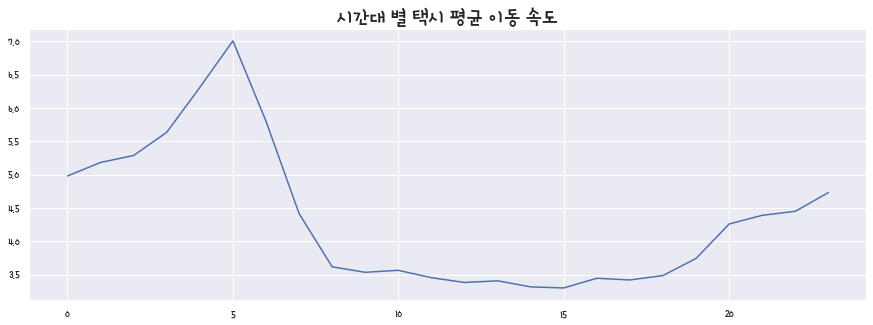

In [33]:
#plt.subplot(221)
f = plt.figure(figsize=(15,5))
plt.title("시간대 별 택시 평균 이동 속도", fontsize=20) 
plot(train.groupby('pickup_hour').mean()['avg_spped_u'])
plt.show()

### 가설3) 승객수가 많을수록 특정 포인트에서 많이 탈것이다.
### → 결과: 승객수는 크게 영향을 주지 않음. 택시 탑승 위치는 뉴욕 맨하탄에서 가장 많음.

### * 택시 이동 경로 데이터 시각화

### ① 승객수 Top 300 택시 탑승 위치

In [34]:
dfm=train[['passenger_count','pickup_latitude','pickup_longitude']]
dfm_top = dfm.sort_values(by=['passenger_count'],ascending=False).head(300)
map_osm = folium.Map(location = [40.7222902,-73.8615555], zoom_start = 11)

In [35]:
for item in dfm_top.index:
    lat = dfm_top.loc[item, 'pickup_latitude']
    long = dfm_top.loc[item, 'pickup_longitude']
    folium.CircleMarker([lat,long],
                        radius=dfm_top.loc[item, 'passenger_count']/0.8,
                        popup=dfm_top.loc[item,'passenger_count'],
                        color='red',
                        fill=True).add_to(map_osm)
map_osm

### ② 승객수 하위 300 승차 위치


In [36]:
dfm=train[['passenger_count','pickup_latitude','pickup_longitude']]
dfm1 = train[train['passenger_count']>0]
dfm_bottom = dfm1.sort_values(by=['passenger_count'],ascending=True).head(300)
map_osm1 = folium.Map(location = [40.7222902,-73.8615555], zoom_start = 11)

In [37]:
for item in dfm_bottom.index:
    lat = dfm_bottom.loc[item, 'pickup_latitude']
    long = dfm_bottom.loc[item, 'pickup_longitude']
    folium.CircleMarker([lat,long],
                        radius=dfm_bottom.loc[item, 'passenger_count']/0.8,
                        popup=dfm_bottom.loc[item,'passenger_count'],
                        color='blue',
                        fill=True).add_to(map_osm1)
map_osm1

## 군집분석

In [42]:
# percentile을 사용하여 이상치 제거

allLat  = np.array(list(train['pickup_latitude'])  + list(train['dropoff_latitude']))
allLong = np.array(list(train['pickup_longitude']) + list(train['dropoff_longitude']))

xlim = [np.percentile(allLong, 0.3), np.percentile(allLong, 99.7)]
ylim = [np.percentile(allLat , 0.3), np.percentile(allLat , 99.7)]

train = train[(train.pickup_longitude> xlim[0]) & (train.pickup_longitude < xlim[1])]
train = train[(train.dropoff_longitude> xlim[0]) & (train.dropoff_longitude < xlim[1])]
train = train[(train.pickup_latitude> ylim[0]) & (train.pickup_latitude < ylim[1])]
train = train[(train.dropoff_latitude> ylim[0]) & (train.dropoff_latitude < ylim[1])]

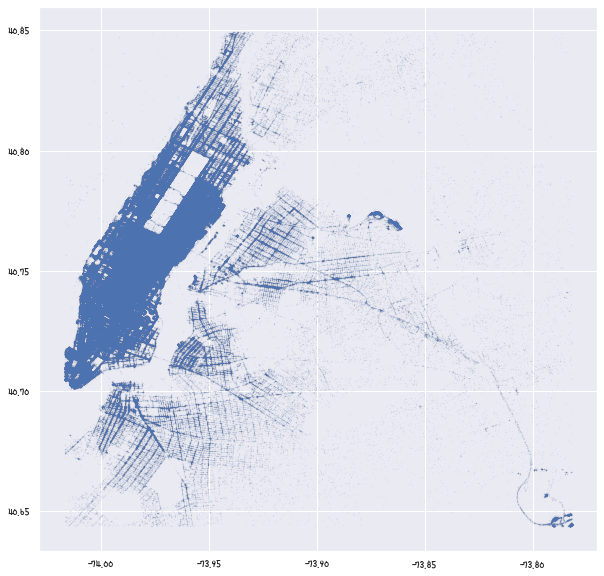

In [44]:
# longitude와 loatitude 합쳐서 봐본다. 
# 가능한 이유는 
f = plt.figure(figsize=(10,10))
longitude = list(train.pickup_longitude) + list(train.dropoff_longitude)
latitude = list(train.pickup_latitude) + list(train.dropoff_latitude)
plt.plot(longitude, latitude,'.', markersize=0.05)
plt.show()

##### kmeans 클러스터링을 이용해 구역 구분

In [45]:
loc_df = pd.DataFrame()
loc_df['longitude'] = longitude
loc_df['latitude'] = latitude
#loc_df.head()

##### kmeans 클러스터링, default 값인 8로 구분

In [46]:
K = 8
kmeans = KMeans(n_clusters = K, random_state=2).fit(loc_df)
kmeans

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=2, tol=0.0001, verbose=0)

In [47]:
# 0~7 label로 구분 되어있으며 train data에 label 값 붙여주기
loc_df['label'] = kmeans.labels_

In [48]:
train['labels'] = loc_df['label']

In [49]:
# 구역별 passenger 수
train.groupby(train.labels).size()

labels
0    200771
1    383248
2    210560
3     28934
4     96071
5    408446
6      5942
7     22618
dtype: int64

In [50]:
# sample 20000 개만 추출해서 관찰
loc_df1 = loc_df.sample(20000)
loc_df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 796553 to 1347463
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   longitude  20000 non-null  float64
 1   latitude   20000 non-null  float64
 2   label      20000 non-null  int32  
dtypes: float64(2), int32(1)
memory usage: 546.9 KB


In [51]:
# kmeans를 8개로 나누고 중심으로 많이 모이는 곳을 찾아보기 위해 cluster_center 확인
kmeans.cluster_centers_

array([[-73.95492017,  40.77232519],
       [-73.99106854,  40.74360307],
       [-73.99999873,  40.72047151],
       [-73.87495858,  40.76582437],
       [-73.96135437,  40.79803877],
       [-73.97861127,  40.7619019 ],
       [-73.7960046 ,  40.66059019],
       [-73.96198756,  40.69354657]])

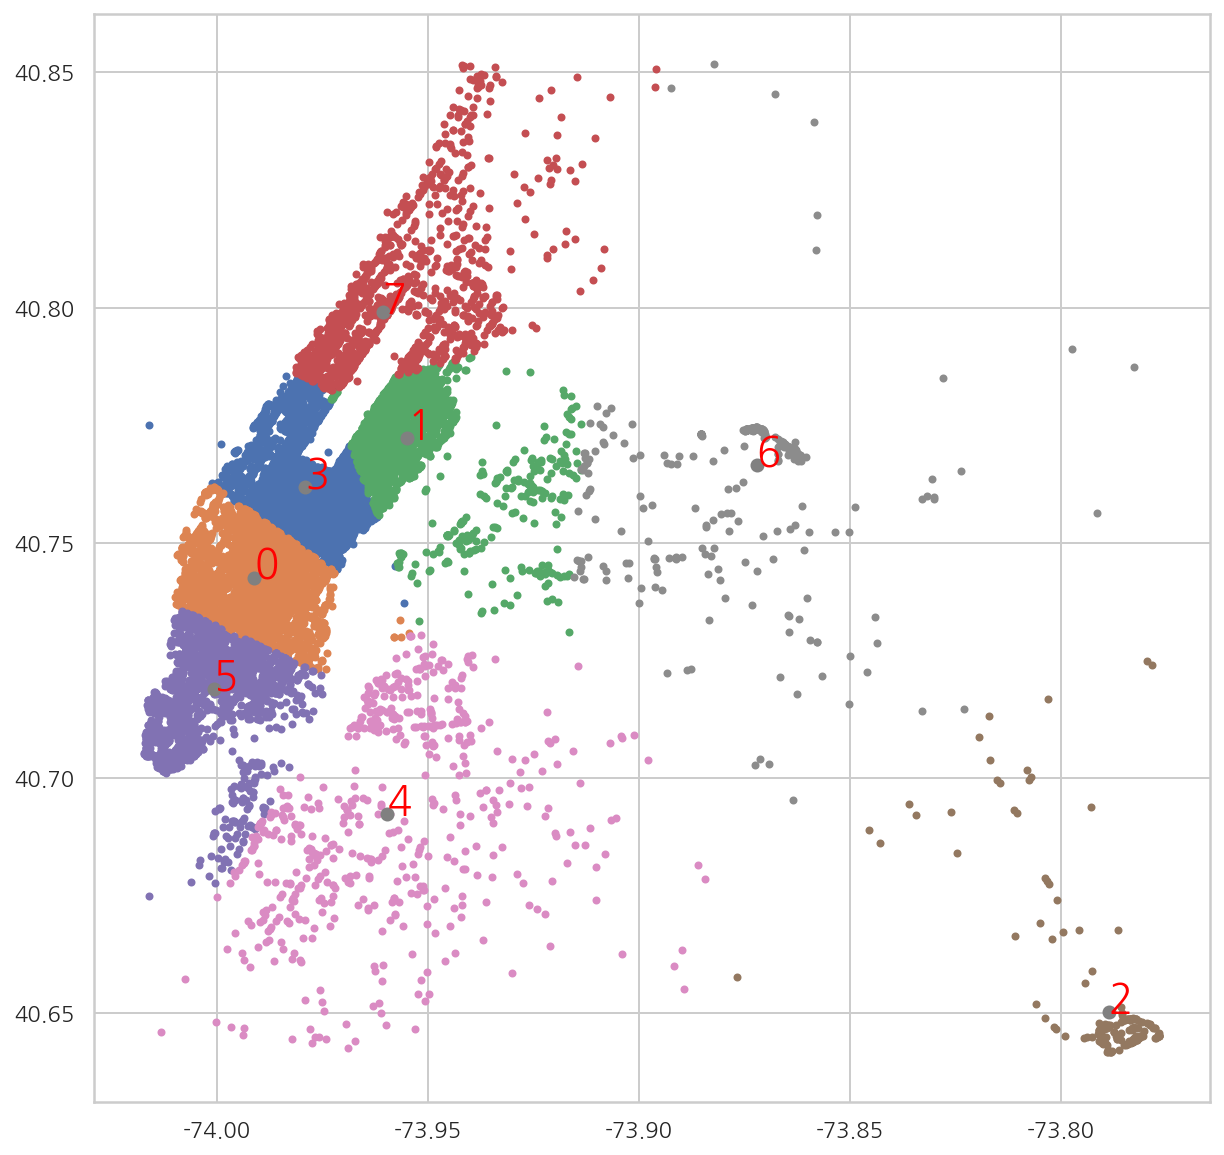

In [41]:
fig, ax = plt.subplots(figsize = (10,10))
for label in loc_df1.label.unique():
    ax.plot(loc_df1.longitude[loc_df1.label == label],loc_df1.latitude[loc_df1.label == label],'.')
    ax.plot(kmeans.cluster_centers_[label, 0], kmeans.cluster_centers_[label, 1],'o', color = 'gray')
    ax.annotate(label, (kmeans.cluster_centers_[label, 0], kmeans.cluster_centers_[label, 1]), fontsize = 20, color = 'red')

In [53]:
# 구역별 passenger 수
train.groupby(train.labels).size()

labels
0    200771
1    383248
2    210560
3     28934
4     96071
5    408446
6      5942
7     22618
dtype: int64

### 위치 데이터 - 출처 : kaggle 

In [43]:
neighborhood = {-74.0019368351: 'Chelsea',-73.837549761: 'Queens',-73.7854240738: 'JFK',-73.9810421975:'Midtown-North-West',-73.9862336241: 'East Village',
                -73.971273324:'Midtown-North-East',-73.9866739677: 'Brooklyn-parkslope',-73.8690098118: 'LaGuardia',-73.9890572967:'Midtown',-74.0081765545: 'Downtown'
                ,-73.9213024854: 'Queens-Astoria',-73.9470256923: 'Harlem',-73.9555565018: 'Uppe East Side',
               -73.9453487097: 'Brooklyn-Williamsburgt',-73.9745967889:'Upper West Side'}

### 가설 4) 날씨가 안좋으면 택시를 많이 탈 것이다.
### → 결과: 200개 샘플링 결과, 날씨는 크게 상관 관계를 발견하지 못하였음. (dark sky 하루 이용 건수(1000건) 제한으로, 날씨 데이터를 전부 다 가져오기에 한계가 있어서 개수 제한하였음. 샘플링에 따라 결과가 달라지긴 함. )

###  ① 탑승 시점(2016 데이터) 가져오기 위해, 날짜 타입의 pickup_datetime을 int로 형변환

In [54]:
train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'])

In [55]:
sample_train = train.sample(n=200).reset_index(drop=True)

In [56]:
time = []
for i in range(0,len(sample_train)):
    time.append(int(sample_train['pickup_datetime'][i].timestamp()))

sample_train['pickup_datetime(int)']= pd.DataFrame(time)

###  ② Darksky API에서 택시 탑승 시점의 날씨 가져오기

In [57]:
# key = "4d70006c9f3fe7eb142d68552557826b"
lat, lng = sample_train["pickup_latitude"], sample_train["pickup_longitude"]

In [59]:
weather=[]

for random_index in range(0,len(sample_train)):
    url = "https://api.darksky.net/forecast/4d70006c9f3fe7eb142d68552557826b/{},{},{}".format(lat[random_index], lng[random_index], time[random_index])
    response = requests.get(url)
    current_weather = response.json()["currently"]["summary"]
    weather.append(current_weather)
    
sample_train["weather"] = pd.DataFrame(weather)

In [60]:
sample_train["trip_duration(minute)"] = sample_train["trip_duration"] // 60

### ③ 날씨와 이동 시간의 관계

### *날씨 One Hot Encoding( 0 : Clear, Partly Cloudy // 1: Overcast, Lightsnow, Possible Drizzle, Light Rain)

In [50]:
sample_train["weather"].unique()

array(['Clear', 'Overcast', 'Possible Drizzle', 'Partly Cloudy',
       'Mostly Cloudy', 'Light Rain', 'Drizzle', 'Possible Light Rain',
       'Possible Flurries', 'Foggy'], dtype=object)

In [51]:
sample_train["bad_weather"] = sample_train["weather"].apply(lambda data: 0 if data  == "Clear" or data == "Partly Cloudy" else 1)

### *날씨와 이동시간 상관계수

In [52]:
np.corrcoef(sample_train['trip_duration(minute)'], sample_train["bad_weather"])

array([[1.        , 0.02396467],
       [0.02396467, 1.        ]])

In [56]:
a = stats.pearsonr(sample_train['trip_duration(minute)'], sample_train["bad_weather"])
a

(0.032341922144001944, 0.6620892296204139)

### *날씨에 따른 탑승 시간, 이동 시간 분포

In [53]:
sample_train = sample_train[sample_train["trip_duration(minute)"]<30]

<Figure size 1080x504 with 0 Axes>

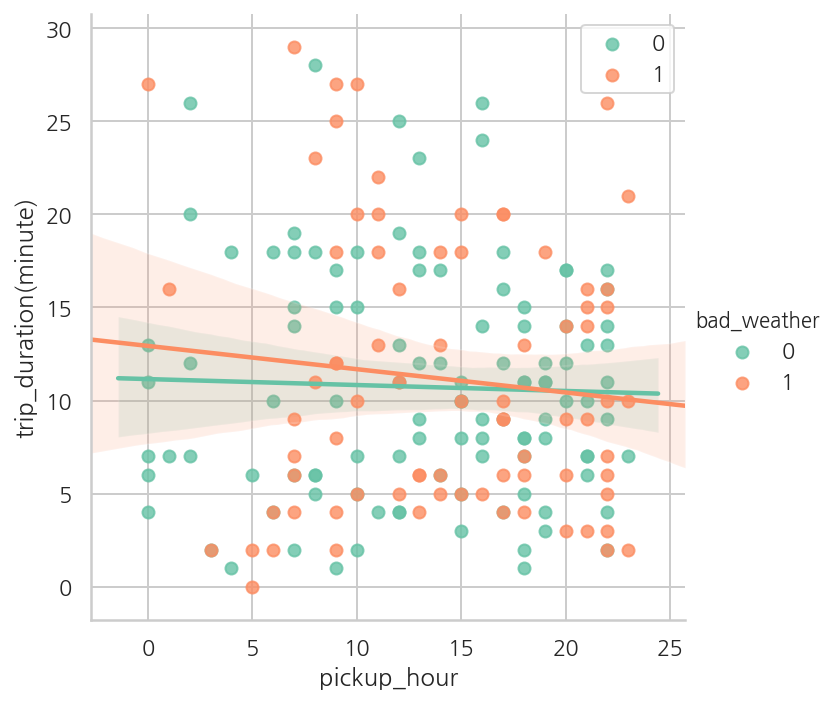

In [54]:
f = plt.figure(figsize=(15,7))

sns.lmplot( x="pickup_hour", y="trip_duration(minute)", data=sample_train, fit_reg=True, hue='bad_weather', legend=True, palette="Set2")
 
plt.legend(loc='upper right')
plt.show()